In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metrics(df_ssim, bands=['B02', 'B03', 'B04'],
                 title="SSIM Metrics Over Training Epochs",
                 save_path="ssim_metrics_plot.svg",
                 color_palette="plasma"):
    """
    Plot SSIM metrics with customizable bands, title and color palette.

    Args:
        df_ssim (DataFrame): DataFrame containing SSIM metrics
        bands (list): List of band names to plot
        title (str): Plot title
        save_path (str): Path to save the figure
        color_palette (str): Name of color palette to use
    """
    # Set up color palette
    colors = sns.color_palette(color_palette, len(bands))

    # Create figure
    plt.figure(figsize=(10, 6))

    # Loop through bands to plot
    for i, band in enumerate(bands):
        # Plot training curves (dashed)
        plt.plot(df_ssim['epoch'], df_ssim[f'train_{band}'], '--',
                label=f'Train {band}', color=colors[i])

        # Plot validation curves (solid)
        plt.plot(df_ssim['epoch'], df_ssim[f'val_{band}'],
                label=f'Val {band}', color=colors[i])

    # Add labels and title
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Save and show
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

In [37]:
df_ssim = pd.read_csv("/home/ubuntu/project/sentinel-2-ai-processor/src/checkpoints/ssim_metrics.csv")
df_sam = pd.read_csv("/home/ubuntu/project/sentinel-2-ai-processor/src/checkpoints/sam_metrics.csv")
df_rmse = pd.read_csv("/home/ubuntu/project/sentinel-2-ai-processor/src/checkpoints/rmse_metrics.csv")
df_psnr = pd.read_csv("/home/ubuntu/project/sentinel-2-ai-processor/src/checkpoints/psnr_metrics.csv")

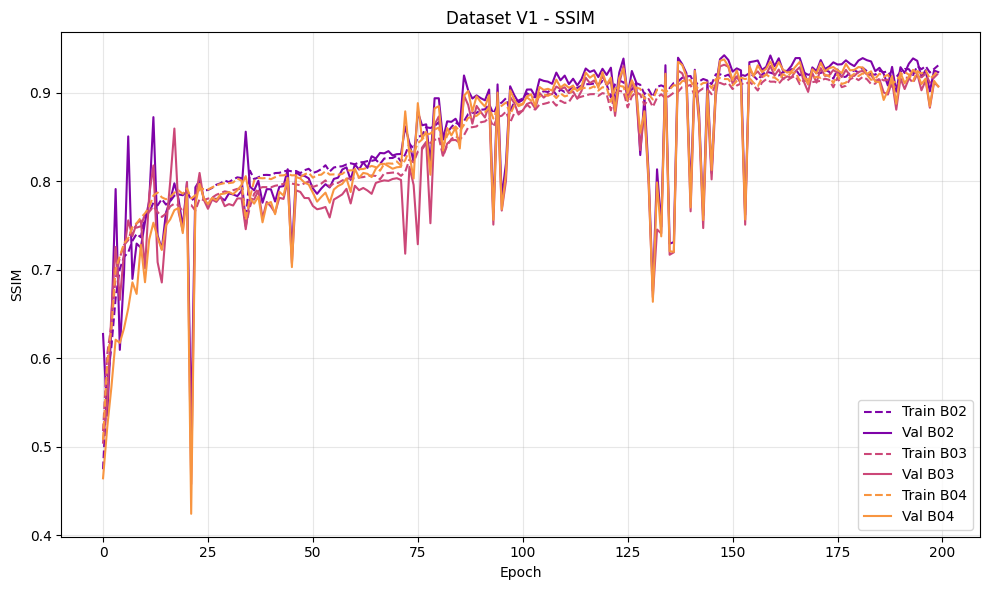

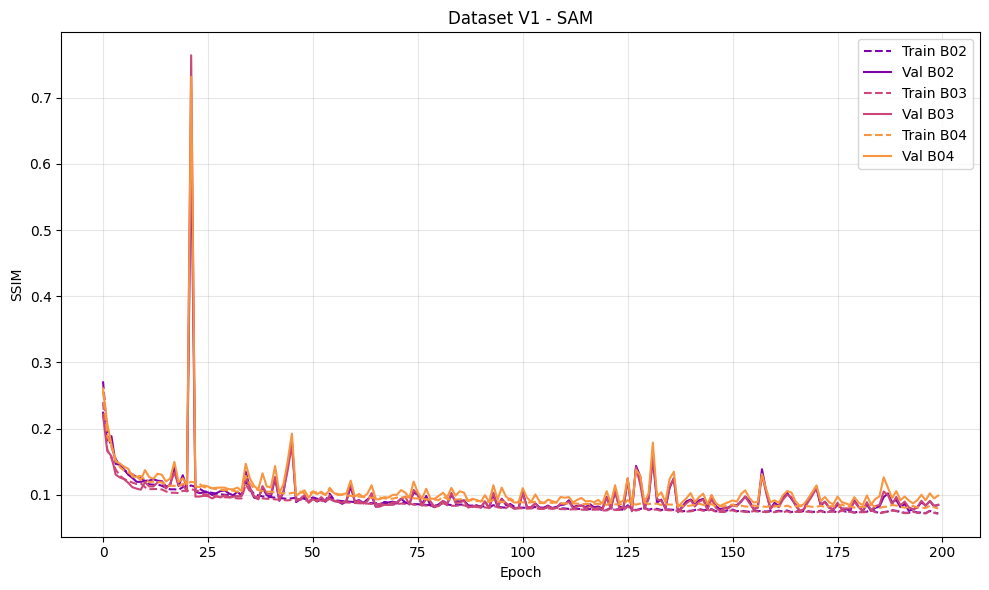

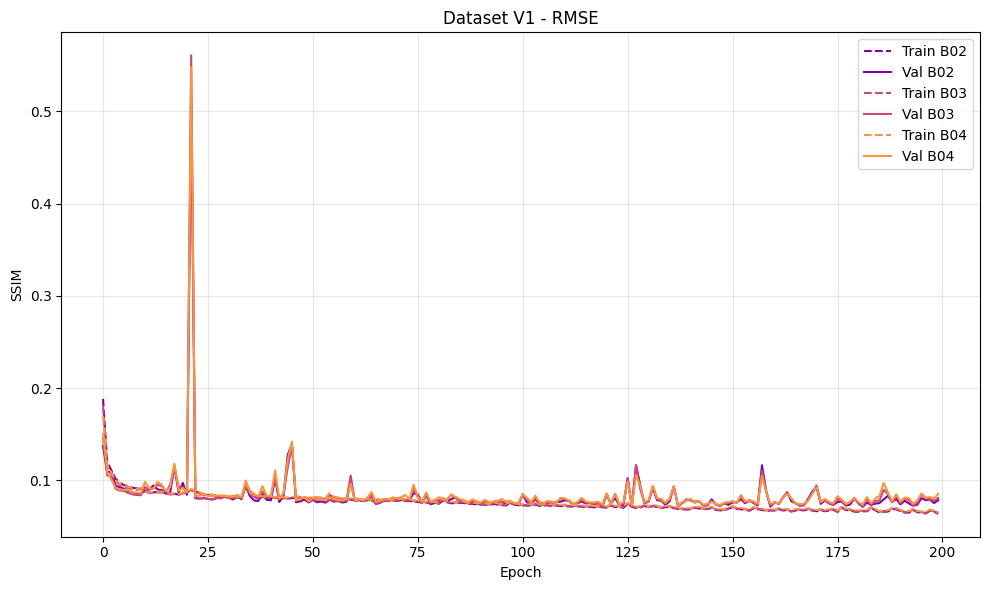

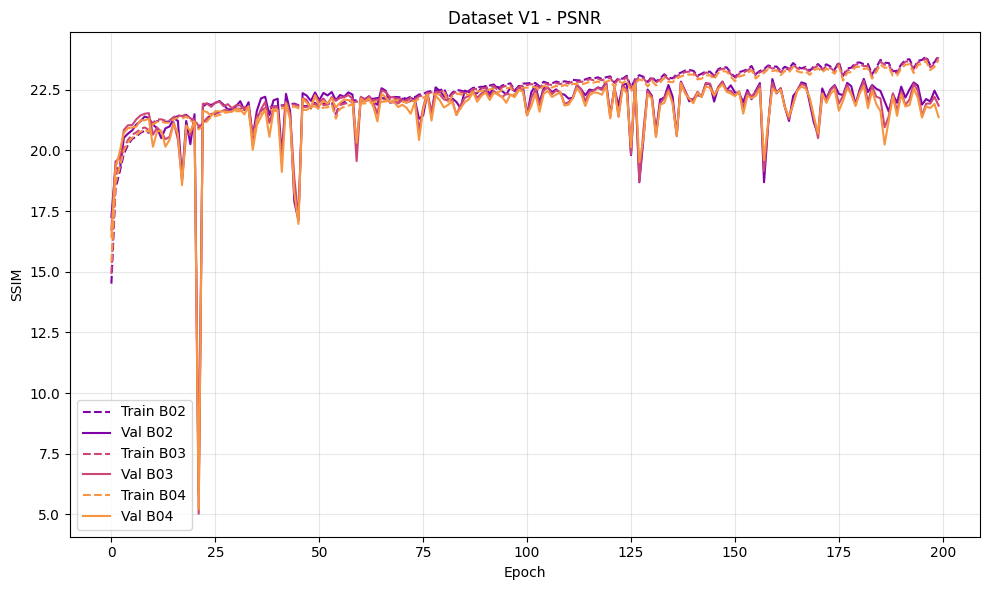

In [39]:
bands = ['B02', 'B03', 'B04']
plot_metrics(df_ssim, bands=bands, title="Dataset V1 - SSIM",
             save_path="ssim_metrics_plot.svg",
             color_palette="plasma")
plot_metrics(df_sam, bands=bands, title="Dataset V1 - SAM",
             save_path="sam_metrics_plot.svg",
             color_palette="plasma")
plot_metrics(df_rmse, bands=bands, title="Dataset V1 - RMSE",
             save_path="rmse_metrics_plot.svg",
             color_palette="plasma")
plot_metrics(df_psnr, bands=bands, title="Dataset V1 - PSNR",
             save_path="psnr_metrics_plot.svg",
             color_palette="plasma")
